# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

# Read Treasury Yield Data to Pandas

In [2]:
yield_df = pd.read_excel('10_year_yield.xls', header=10)
yield_df.dropna(inplace = True)
yield_df = yield_df[yield_df['Observation Date'] > '01-01-1990']
yield_df.set_index('Observation Date', inplace = True)

In [3]:
yield_df.head()

,Yield
Observation Date,
1990-01-02,7.94
1990-01-03,7.99
1990-01-04,7.98
1990-01-05,7.99
1990-01-08,8.02


# Graph Data

Text(0.5, 1.0, 'Daily 10 Year Treasury Yield Since 1990')

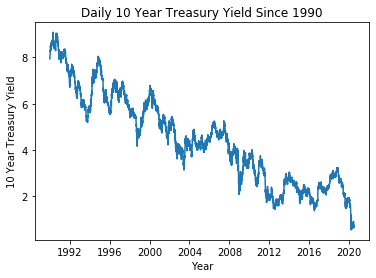

In [4]:
x = yield_df.index
y = yield_df['Yield']
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel('Year')
ax.set_ylabel('10 Year Treasury Yield')
ax.set_title('Daily 10 Year Treasury Yield Since 1990')

# Remove Data Trends

In [5]:
yield_df_dif = yield_df.diff(periods=1)
yield_df_dif.head()

,Yield
Observation Date,
1990-01-02,NaN
1990-01-03,0.05
1990-01-04,-0.01
1990-01-05,0.01
1990-01-08,0.03


Text(0.5, 1.0, 'Daily 10 Year Treasury Yield Since 1990')

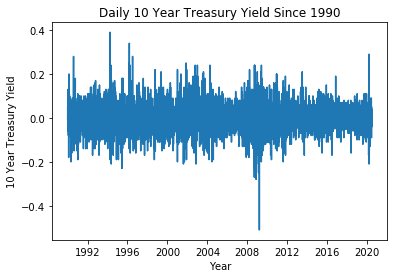

In [6]:
x = yield_df_dif.index
y = yield_df_dif['Yield']
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel('Year')
ax.set_ylabel('10 Year Treasury Yield')
ax.set_title('Differenced 10 Year Treasury Yield Since 1990')

# Dickey Fuller Test

In [7]:
dftest = adfuller(yield_df_dif.iloc[1:,])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput


Test Statistic                  -22.251584
p-value                           0.000000
#Lags Used                       13.000000
Number of Observations Used    7616.000000
Critical Value (1%)              -3.431209
Critical Value (5%)              -2.861920
Critical Value (10%)             -2.566972
dtype: float64

In [17]:
yield_df_dif

,Yield
Observation Date,
1990-01-02,NaN
1990-01-03,0.05
1990-01-04,-0.01
1990-01-05,0.01
1990-01-08,0.03
...,...
2020-06-25,-0.01
2020-06-26,-0.04
2020-06-29,0.00


# Plot ACF and PACF

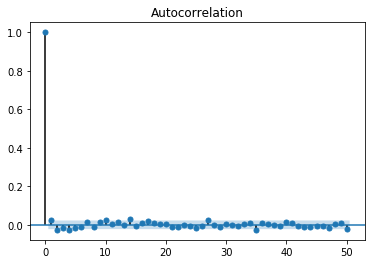

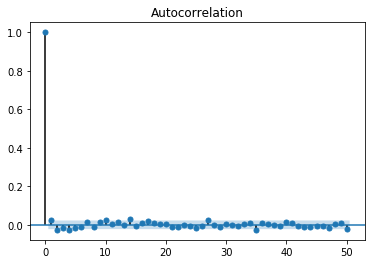

In [22]:
plot_acf(yield_df_dif.iloc[1:,], alpha=.05, lags = 50)

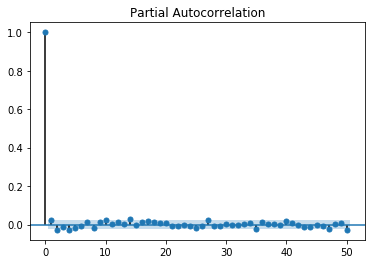

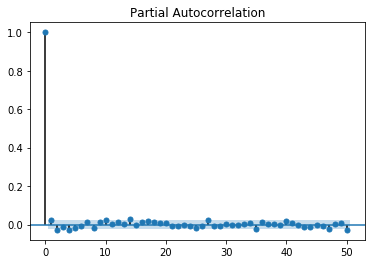

In [9]:
plot_pacf(yield_df_dif.iloc[1:,], alpha=.05, lags=50)

# Persistence Model

In [12]:
#Persistence Model code based upon https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/
persistence_yield_df = pd.concat([yield_df.shift(1), yield_df], axis=1)
persistence_yield_df.columns = ['Prior Yield', 'Yield']
persistence_yield_df.head()

,Prior Yield,Yield
Observation Date,,
1990-01-02,NaN,7.94
1990-01-03,7.94,7.99
1990-01-04,7.99,7.98
1990-01-05,7.98,7.99
1990-01-08,7.99,8.02


In [13]:
values = persistence_yield_df.values
train_size = int(len(values)*.75)
train, test = values[1:train_size], values[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [14]:
predictions = []
for x in test_X:
    predictions.append(x)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.002


# ARMA Model

In [23]:
mod_arma = ARMA(yield_df, order=(1,0))
res_arma = mod_arma.fit()
print(res_arma.summary())
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                  Yield   No. Observations:                 7631
Model:                     ARMA(1, 0)   Log Likelihood               10927.544
Method:                       css-mle   S.D. of innovations              0.058
Date:                Sat, 12 Sep 2020   AIC                         -21849.088
Time:                        21:18:16   BIC                         -21828.269
Sample:                             0   HQIC                        -21841.945
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.3796      1.959      2.236      0.025       0.540       8.219
ar.L1.Yield     0.9998      0.000   4262.280      0.000       0.999       1.000
                                    Roots       

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
mod_arma.predict

# FBProphet

In [24]:
##Persistence Model code based upon https://facebook.github.io/prophet/docs/quick_start.html
indexed_yield_df = yield_df.reset_index()
indexed_yield_df.columns = ['ds', 'y']
prophet = Prophet()
prophet.fit(indexed_yield_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
future = prophet.make_future_dataframe(periods=10000)
future.tail()
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
17626,2047-11-13,-0.299098,-94.943330,105.186238
17627,2047-11-14,-0.299175,-94.766159,105.128515
17628,2047-11-15,-0.304730,-94.901426,105.105242
17629,2047-11-16,-0.913887,-95.550134,105.019196
17630,2047-11-17,-0.916199,-95.598073,104.614192


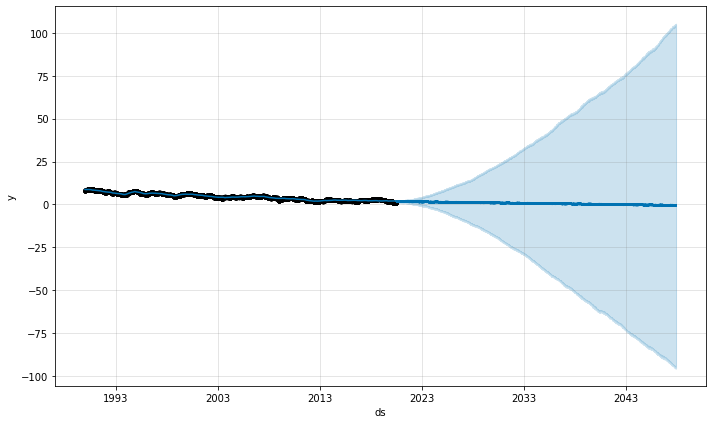

In [32]:
fig1 = prophet.plot(forecast)

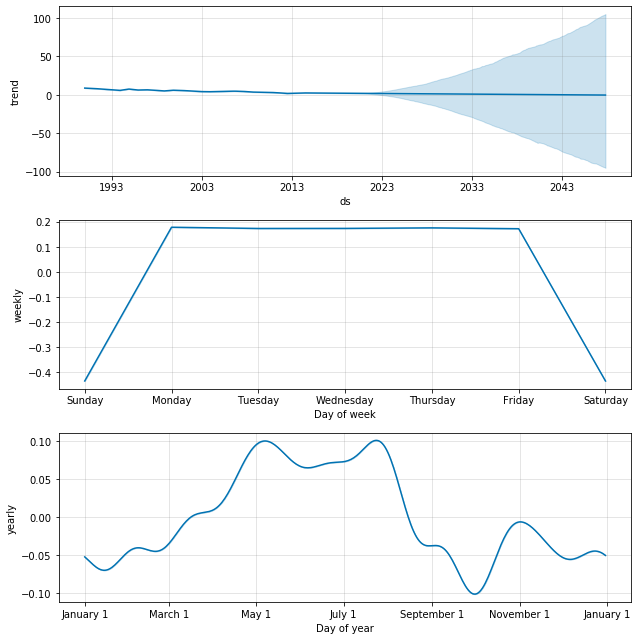

In [33]:
fig2 = prophet.plot_components(forecast)

In [36]:
forecast[forecast['trend'] < 0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
15604,2042-05-01,-0.000165,-69.613550,73.563363,-69.717594,72.904464,0.269812,0.269812,0.269812,0.175091,0.175091,0.175091,0.094721,0.094721,0.094721,0.0,0.0,0.0,0.269648
15605,2042-05-02,-0.000389,-69.389902,73.216398,-69.724068,72.914332,0.268006,0.268006,0.268006,0.171757,0.171757,0.171757,0.096249,0.096249,0.096249,0.0,0.0,0.0,0.267617
15606,2042-05-03,-0.000613,-70.097270,72.690460,-69.730542,72.924200,-0.337620,-0.337620,-0.337620,-0.435126,-0.435126,-0.435126,0.097505,0.097505,0.097505,0.0,0.0,0.0,-0.338233
15607,2042-05-04,-0.000837,-70.123756,72.411531,-69.737015,72.934068,-0.336635,-0.336635,-0.336635,-0.435126,-0.435126,-0.435126,0.098491,0.098491,0.098491,0.0,0.0,0.0,-0.337472
15608,2042-05-05,-0.001061,-69.282571,73.077628,-69.743489,72.943936,0.276852,0.276852,0.276852,0.177644,0.177644,0.177644,0.099207,0.099207,0.099207,0.0,0.0,0.0,0.275791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17626,2047-11-13,-0.453258,-94.943330,105.186238,-95.137154,104.816505,0.154160,0.154160,0.154160,0.173012,0.173012,0.173012,-0.018851,-0.018851,-0.018851,0.0,0.0,0.0,-0.299098
17627,2047-11-14,-0.453482,-94.766159,105.128515,-95.147018,104.843643,0.154307,0.154307,0.154307,0.175091,0.175091,0.175091,-0.020784,-0.020784,-0.020784,0.0,0.0,0.0,-0.299175
17628,2047-11-15,-0.453706,-94.901426,105.105242,-95.156881,104.870782,0.148976,0.148976,0.148976,0.171757,0.171757,0.171757,-0.022781,-0.022781,-0.022781,0.0,0.0,0.0,-0.304730
17629,2047-11-16,-0.453931,-95.550134,105.019196,-95.166744,104.897921,-0.459956,-0.459956,-0.459956,-0.435126,-0.435126,-0.435126,-0.024830,-0.024830,-0.024830,0.0,0.0,0.0,-0.913887
